In [20]:
# Standard library imports
import time

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
from IPython.display import Image, display

# Scipy imports
from scipy.stats import chi2_contingency

# Scikit-learn imports
from sklearn.model_selection import (
    train_test_split, cross_val_score, cross_val_predict, cross_validate,
    RandomizedSearchCV, StratifiedKFold
)
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    recall_score, f1_score, precision_score, matthews_corrcoef,
    average_precision_score, roc_auc_score, roc_curve,
    precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# Imbalanced-learn imports
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# XGBoost and LightGBM imports
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [21]:
# Read in the cleaned dataset

df = pd.read_csv('cleaned_patient_data.csv')
df.head()

,Year,Gender,Age,Location,Race : African American,Race : Asian,Race : Caucasian,Race : Hispanic,Race : Other,Hypertension,...,Smoking History,BMI,HbA1c Level,Blood Glucose Level,Diabetes,Combined Risk Factors,BMI_Category,Blood_Glucose_Category,HbA1c_Category,Smoking History Grouped
0,2020,Female,32.0,Alabama,0,0,0,0,1,0,...,never,27.32,5.0,100,0,0,Overweight,Prediabetes,Normal,never
1,2015,Female,29.0,Alabama,0,1,0,0,0,0,...,never,19.95,5.0,90,0,0,Normal weight,Normal,Normal,never
2,2015,Male,18.0,Alabama,0,0,0,0,1,0,...,never,23.76,4.8,160,0,0,Normal weight,Diabetes,Normal,never
3,2015,Male,41.0,Alabama,0,0,1,0,0,0,...,never,27.32,4.0,159,0,0,Overweight,Diabetes,Normal,never
4,2016,Female,52.0,Alabama,1,0,0,0,0,0,...,never,23.75,6.5,90,0,0,Normal weight,Normal,Diabetes,never


In [22]:
df.columns

Index(['Year', 'Gender', 'Age', 'Location', 'Race : African American',
       'Race : Asian', 'Race : Caucasian', 'Race : Hispanic', 'Race : Other',
       'Hypertension', 'Heart Disease', 'Smoking History', 'BMI',
       'HbA1c Level', 'Blood Glucose Level', 'Diabetes',
       'Combined Risk Factors', 'BMI_Category', 'Blood_Glucose_Category',
       'HbA1c_Category', 'Smoking History Grouped'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99986 entries, 0 to 99985
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Year                     99986 non-null  int64  
 1   Gender                   99986 non-null  object 
 2   Age                      99986 non-null  float64
 3   Location                 99986 non-null  object 
 4   Race : African American  99986 non-null  int64  
 5   Race : Asian             99986 non-null  int64  
 6   Race : Caucasian         99986 non-null  int64  
 7   Race : Hispanic          99986 non-null  int64  
 8   Race : Other             99986 non-null  int64  
 9   Hypertension             99986 non-null  int64  
 10  Heart Disease            99986 non-null  int64  
 11  Smoking History          99986 non-null  object 
 12  BMI                      99986 non-null  float64
 13  HbA1c Level              99986 non-null  float64
 14  Blood Glucose Level   

In [5]:
# Identify numeric features
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Identify categorical features
categoric_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Print the results
print("Numeric features:", numeric_features)
print("Categorical features:", categoric_features)

Numeric features: ['Year', 'Age', 'Race : African American', 'Race : Asian', 'Race : Caucasian', 'Race : Hispanic', 'Race : Other', 'Hypertension', 'Heart Disease', 'BMI', 'HbA1c Level', 'Blood Glucose Level', 'Diabetes', 'Combined Risk Factors', 'Cluster']
Categorical features: ['Gender', 'Location', 'Smoking History', 'BMI_Category', 'Blood_Glucose_Category', 'HbA1c_Category']


## Compare Baseline Models on the full feature set. 

In [6]:
# Add our baseline data
data = {
    'Model': ['Logistic Regression', 'Random Forest'],
    'Train Acc': [0.972533, 0.999853],
    'Test Acc': [0.97216, 0.96872],
    'Recall': [0.688366, 0.663582],
    'F1 Score': [0.810767, 0.785753],
    'MCC': [0.811260, 0.785052],
    'ROC-AUC': [0.975901, 0.957101],

}

# Create the scoring DataFrame with baseline data
scoring_df = pd.DataFrame(data)

scoring_df


,Model,Train Acc,Test Acc,Recall,F1 Score,MCC,ROC-AUC
0,Logistic Regression,0.972533,0.97216,0.688366,0.810767,0.811260,0.975901
1,Random Forest,0.999853,0.96872,0.663582,0.785753,0.785052,0.957101


In [7]:
# Evaluate baseline LogisticRegression model with full featureset

# Create a `LogisticRegression` function
lr_model = LogisticRegression()

# Get our target feature, drop uninformative

X = df.drop(columns=['Diabetes','Location', 'Year'], axis=1)
y = df['Diabetes']

# Split the data into training and testing sets before encoding
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=44)

# Perform one-hot encoding 
ohe = OneHotEncoder(drop='first', dtype='int', sparse_output=False, handle_unknown='ignore')
X_train_encoded = ohe.fit_transform(X_train)
X_test_encoded = ohe.transform(X_test)

# Fit the model on the encoded training data
lr_model.fit(X_train_encoded, y_train)

# Make predictions on both train and test data
train_predictions = lr_model.predict(X_train_encoded)
test_predictions = lr_model.predict(X_test_encoded)
test_probabilities = lr_model.predict_proba(X_test_encoded)[:, 1]

# Save both the test predictions and actual test values to a DataFrame
results_df = pd.DataFrame({"Predictions": test_predictions, "Actual": y_test})

# Calculate the model's accuracy on both train and test datasets
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)
recall = recall_score(y_test, test_predictions)  
f1 = f1_score(y_test, test_predictions)
mcc = matthews_corrcoef(y_test, test_predictions)
roc_auc = roc_auc_score(y_test, test_probabilities)

# Create a dictionary with the model name and scores
model_scores = {
    'Model': ['LogRegFull'],
    'Train Acc': [train_accuracy],
    'Test Acc': [test_accuracy],
    'Recall': [recall],
    'F1 Score': [f1],
    'MCC': [mcc],
    'ROC-AUC': [roc_auc]
}

# Convert the dictionary to a DataFrame
model_df = pd.DataFrame(model_scores)

# Concatenate this DataFrame with your existing scoring_df
scoring_df = pd.concat([scoring_df, model_df], ignore_index=True)

# Display the updated scoring DataFrame
display(scoring_df)

# create a copy to use for comparison with the final model
comparison_df = model_df.copy()

c:\Users\16148\anaconda3\envs\dev\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,Model,Train Acc,Test Acc,Recall,F1 Score,MCC,ROC-AUC
0,Logistic Regression,0.972533,0.972160,0.688366,0.810767,0.811260,0.975901
1,Random Forest,0.999853,0.968720,0.663582,0.785753,0.785052,0.957101
2,LogRegFull,0.973423,0.972357,0.696555,0.810321,0.808431,0.978381


In [8]:
# Evalue the RandomForest Model with full featureset

# Drop columns that won't be useful
dropped_df = df.drop(columns=['Location', 'Year'])

# Get our target feature
X = dropped_df.drop(columns='Diabetes')
y = df['Diabetes']

# Split into our test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=27)

# Define the columns to encode
columns_to_encode = ['Gender', 'Smoking History', 'BMI_Category', 'Blood_Glucose_Category', 'HbA1c_Category']

# Create the ColumnTransformer
ct = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore'), columns_to_encode)
], remainder='passthrough')

# Fit on the training data and transform both training and test data
X_train_encoded = ct.fit_transform(X_train)
X_test_encoded = ct.transform(X_test)

# Create and fit our model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_encoded, y_train)

# Make predictions on both train and test data
train_predictions = model.predict(X_train_encoded)
test_predictions = model.predict(X_test_encoded)

# For ROC-AUC, we need probability predictions
train_prob_predictions = model.predict_proba(X_train_encoded)[:, 1]
test_prob_predictions = model.predict_proba(X_test_encoded)[:, 1]

# Calculate the metrics for Random Forest
rf_train_accuracy = accuracy_score(y_train, train_predictions)
rf_test_accuracy = accuracy_score(y_test, test_predictions)
rf_recall = recall_score(y_test, test_predictions)
rf_f1 = f1_score(y_test, test_predictions)
rf_mcc = matthews_corrcoef(y_test, test_predictions)
rf_roc_auc = roc_auc_score(y_test, test_prob_predictions)

# Create a dictionary with the Random Forest model name and scores
rf_model_scores = {
    'Model': ['RFFull'],
    'Train Acc': [rf_train_accuracy],
    'Test Acc': [rf_test_accuracy],
    'Recall': [rf_recall],
    'F1 Score': [rf_f1],
    'MCC': [rf_mcc],
    'ROC-AUC': [rf_roc_auc]
}

# Convert the dictionary to a DataFrame
rf_model_df = pd.DataFrame(rf_model_scores)

# Concatenate this DataFrame with your existing scoring_df
scoring_df = pd.concat([scoring_df, rf_model_df], ignore_index=True)

# Display the updated scoring DataFrame
print("\nUpdated Scoring DataFrame:")
display(scoring_df)


Updated Scoring DataFrame:


,Model,Train Acc,Test Acc,Recall,F1 Score,MCC,ROC-AUC
0,Logistic Regression,0.972533,0.972160,0.688366,0.810767,0.811260,0.975901
1,Random Forest,0.999853,0.968720,0.663582,0.785753,0.785052,0.957101
2,LogRegFull,0.973423,0.972357,0.696555,0.810321,0.808431,0.978381
3,RFFull,0.999733,0.971077,0.679337,0.794076,0.792120,0.965706


### We have an class imbalance, let's try applying weights to our Logistic Regression model

In [9]:
# Create a `LogisticRegression` function
weights = {0: 0.085, 1: 0.915} 
lr_model = LogisticRegression(max_iter=500, random_state=99, class_weight=weights)

dropped_df = df.drop(columns=['Location', 'Year'], axis=1)

# Get our target feature
X = dropped_df.drop(columns='Diabetes')
y = df['Diabetes']

# Split the data into training and testing sets before encoding
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=44)

# Perform one-hot encoding 
ohe = OneHotEncoder(drop='first', dtype='int', sparse_output=False, handle_unknown='ignore')
X_train_encoded = ohe.fit_transform(X_train)
X_test_encoded = ohe.transform(X_test)

# Fit the model on the encoded training data
lr_model.fit(X_train_encoded, y_train)

# Make predictions on both train and test data
train_predictions = lr_model.predict(X_train_encoded)
test_predictions = lr_model.predict(X_test_encoded)
test_probabilities = lr_model.predict_proba(X_test_encoded)[:, 1]

# Save both the test predictions and actual test values to a DataFrame
results_df = pd.DataFrame({"Predictions": test_predictions, "Actual": y_test})

# Calculate the model's accuracy on both train and test datasets
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)
recall = recall_score(y_test, test_predictions)  
f1 = f1_score(y_test, test_predictions)
mcc = matthews_corrcoef(y_test, test_predictions)
roc_auc = roc_auc_score(y_test, test_probabilities)

# Create a dictionary with the model name and scores
model_scores = {
    'Model': ['LogRegWeighted'],
    'Train Acc': [train_accuracy],
    'Test Acc': [test_accuracy],
    'Recall': [recall],
    'F1 Score': [f1],
    'MCC': [mcc],
    'ROC-AUC': [roc_auc]
}

# Convert the dictionary to a DataFrame
model_df = pd.DataFrame(model_scores)

# Concatenate this DataFrame with your existing scoring_df
scoring_df = pd.concat([scoring_df, model_df], ignore_index=True)

# Display the updated scoring DataFrame
display(scoring_df)

c:\Users\16148\anaconda3\envs\dev\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,Model,Train Acc,Test Acc,Recall,F1 Score,MCC,ROC-AUC
0,Logistic Regression,0.972533,0.972160,0.688366,0.810767,0.811260,0.975901
1,Random Forest,0.999853,0.968720,0.663582,0.785753,0.785052,0.957101
2,LogRegFull,0.973423,0.972357,0.696555,0.810321,0.808431,0.978381
3,RFFull,0.999733,0.971077,0.679337,0.794076,0.792120,0.965706
4,LogRegWeighted,0.918308,0.914750,0.909863,0.644062,0.635448,0.978965


,Model,Train Acc,Test Acc,Recall,F1 Score,MCC,ROC-AUC
0,Logistic Regression,0.972533,0.972160,0.688366,0.810767,0.811260,0.975901
1,Random Forest,0.999853,0.968720,0.663582,0.785753,0.785052,0.957101
2,LogRegFull,0.973423,0.972357,0.696555,0.810321,0.808431,0.978381
3,RFFull,0.999733,0.971077,0.679337,0.794076,0.792120,0.965706
4,LogRegWeighted,0.918308,0.914750,0.909863,0.644062,0.635448,0.978965
5,DecisionTreeWeighted,0.914961,0.913710,0.881536,0.638512,0.624437,0.973557


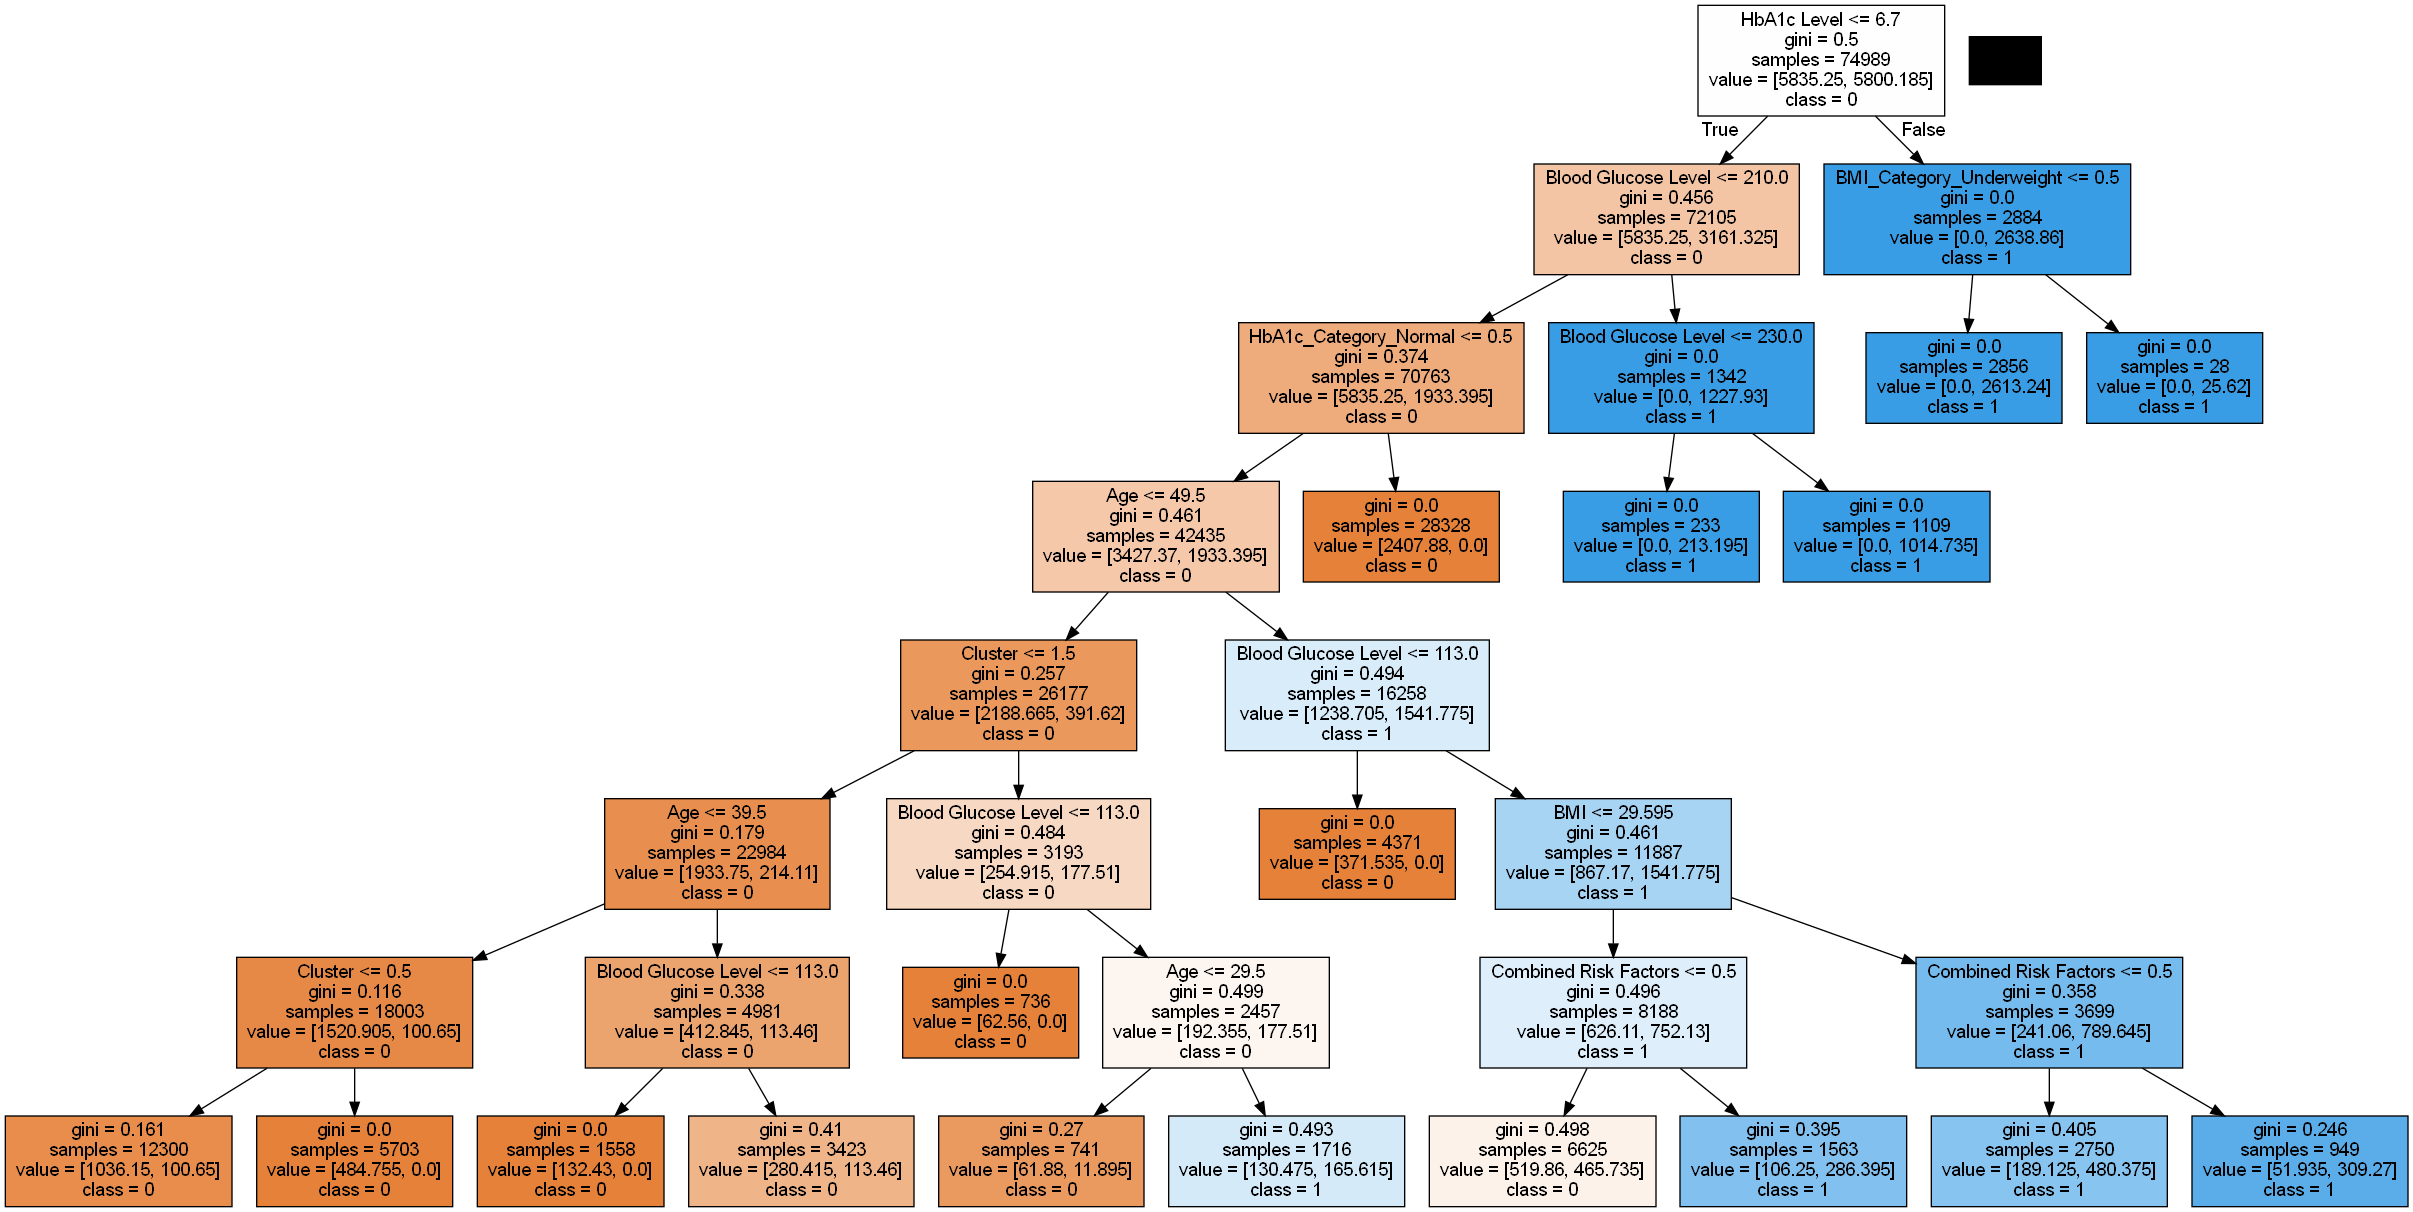

True

In [10]:
# Decision Tree with graphviz
# Prepare the data
y = df['Diabetes']
X = df.drop(columns=['Year', 'Location', 'Diabetes'])

# Identify categorical columns for one-hot encoding
categorical_columns = ['Gender', 'Smoking History', 'BMI_Category', 'Blood_Glucose_Category', 'HbA1c_Category']

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_columns)
    ])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=9)

# Fit the preprocessor and transform the data
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# Get feature names after preprocessing
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = [f"{col}_{val}" for col, vals in 
                        zip(categorical_columns, preprocessor.named_transformers_['cat'].categories_) 
                        for val in vals[1:]]
feature_names = numeric_features + categorical_features

# Create and train the model
tree_model = DecisionTreeClassifier(max_depth=7,
                                    min_samples_split=10, 
                                    min_samples_leaf=5,
                                    random_state=9,
                                    class_weight={0: 0.085, 1: 0.915})
tree_model.fit(X_train_encoded, y_train)

# Make predictions on both train and test data
train_predictions = tree_model.predict(X_train_encoded)
test_predictions = tree_model.predict(X_test_encoded)
test_probabilities = tree_model.predict_proba(X_test_encoded)[:, 1]

# Calculate metrics
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)
recall = recall_score(y_test, test_predictions)
f1 = f1_score(y_test, test_predictions)
mcc = matthews_corrcoef(y_test, test_predictions)
roc_auc = roc_auc_score(y_test, test_probabilities)

# Create a dictionary with the model name and scores
model_scores = {
    'Model': ['DecisionTreeWeighted'],
    'Train Acc': [train_accuracy],
    'Test Acc': [test_accuracy],
    'Recall': [recall],
    'F1 Score': [f1],
    'MCC': [mcc],
    'ROC-AUC': [roc_auc]
}

# Convert the dictionary to a DataFrame
model_df = pd.DataFrame(model_scores)

# Concatenate this DataFrame with your existing scoring_df
scoring_df = pd.concat([scoring_df, model_df], ignore_index=True)

# Display the updated scoring DataFrame
display(scoring_df)

# Graph the Decision Tree
dot_data = export_graphviz(
    tree_model, out_file=None, feature_names=feature_names, class_names=["0", "1"],
    filled=True
)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
display(Image(graph.create_png()))

# Save the tree as PDF
file_path = "decision_tree_weighted.pdf"
graph.write_pdf(file_path)

Was getting a failure to converge warning, so added max_iter = 500 parameter

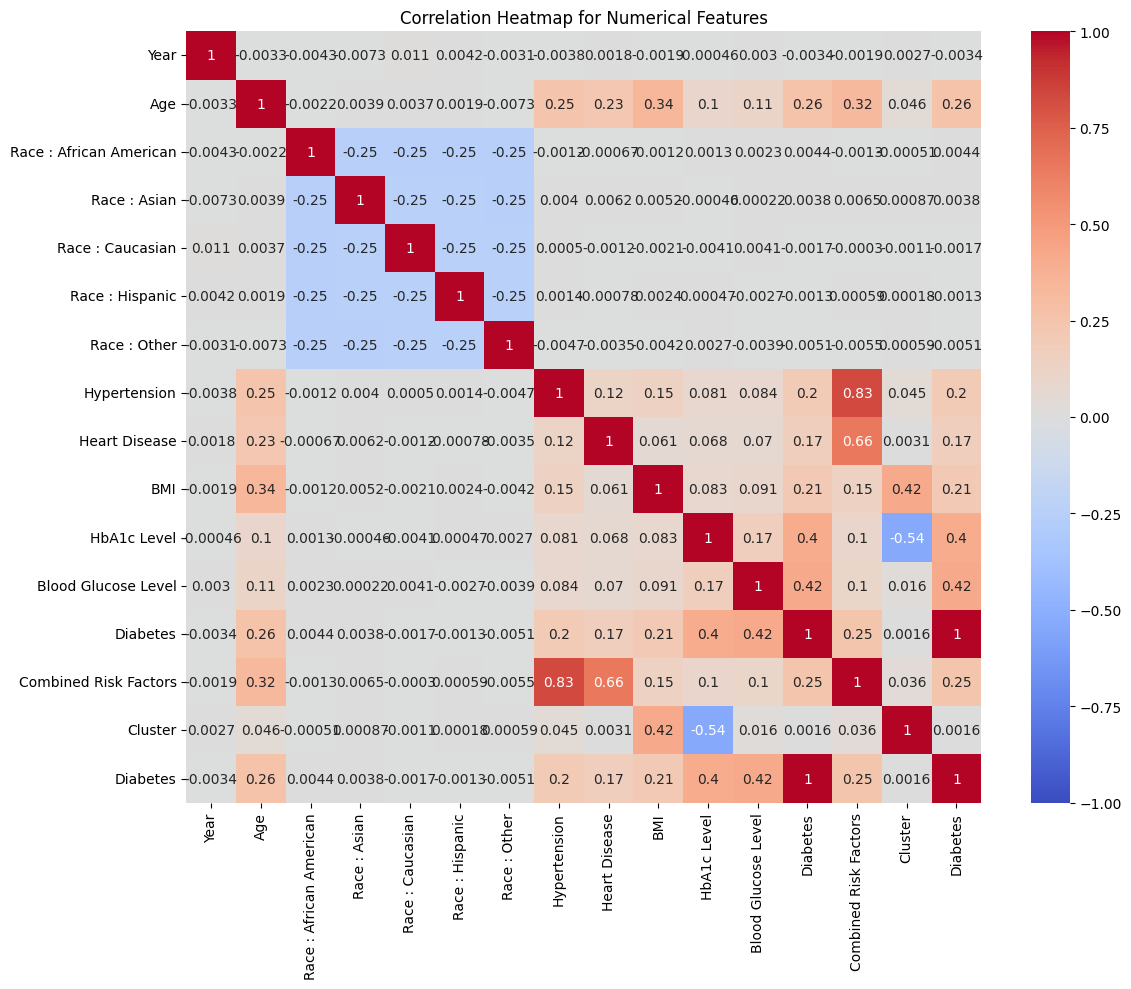

Feature Importances:


c:\Users\16148\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Feature,Importance,Raw_Coefficient
26,HbA1c_Category_Normal,17.475050,0.042191
24,Blood_Glucose_Category_Normal,6.627829,-4.136590
25,Blood_Glucose_Category_Prediabetes,4.552540,-4.184145
5,Race : Other,4.280677,-4.260880
3,Race : Caucasian,4.260880,-4.179259
2,Race : Asian,4.184145,-4.280677
4,Race : Hispanic,4.179259,0.270506
1,Race : African American,4.136590,0.219807
9,HbA1c Level,2.611738,0.024183
16,Smoking History_ever,1.187174,2.611738


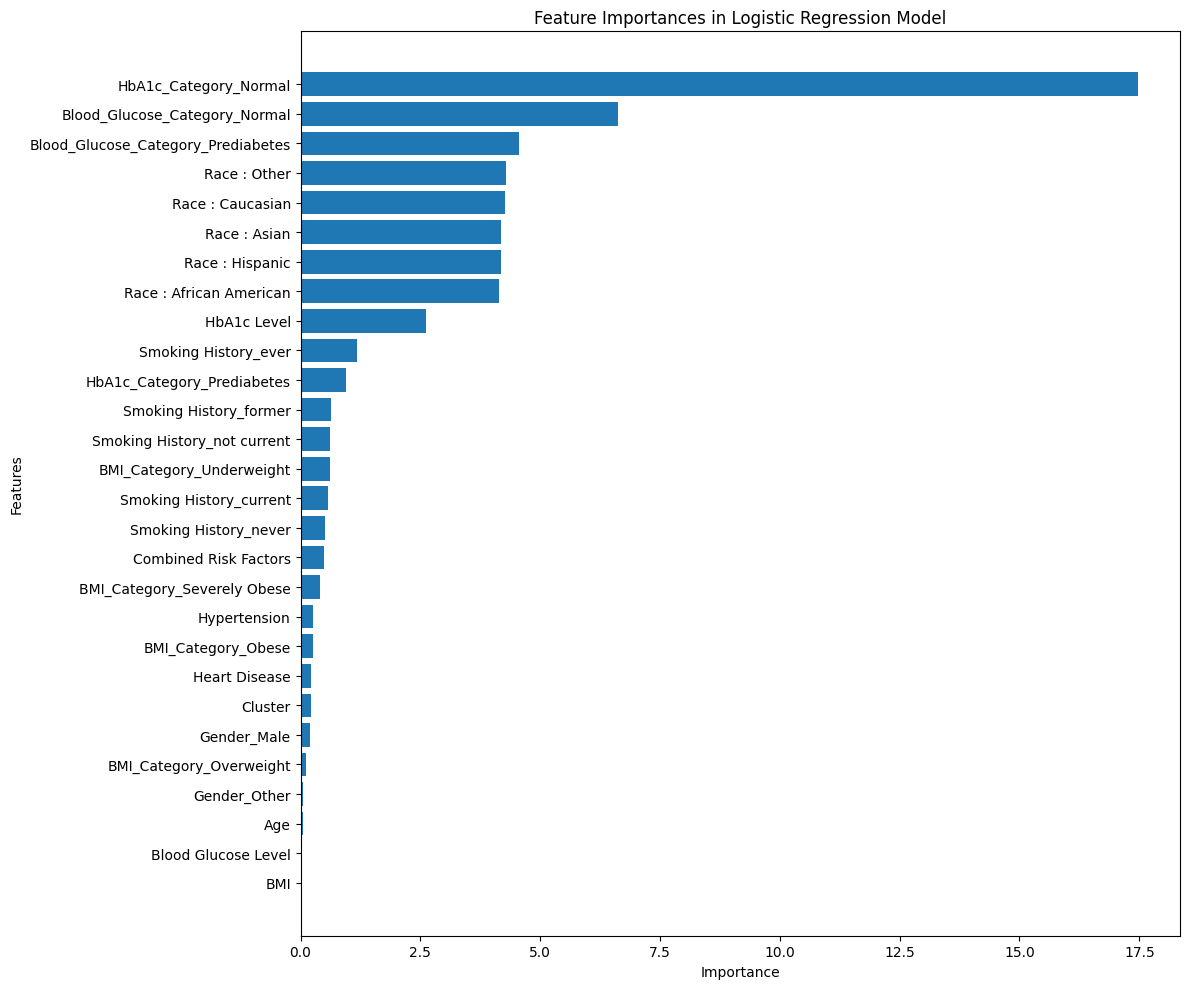

In [11]:
# Examine feature correlation and feature importances for our log reg model

# Separate numerical and categorical features
numerical_features = ['Year', 'Age', 'Race : African American',
                    'Race : Asian', 'Race : Caucasian',
                    'Race : Hispanic', 'Race : Other',
                    'Hypertension', 'Heart Disease',
                    'BMI', 'HbA1c Level', 'Blood Glucose Level',
                    'Diabetes', 'Combined Risk Factors',
                    'Cluster']
categorical_features = ['Gender', 'Location', 'Smoking History', 'BMI_Category', 'Blood_Glucose_Category', 'HbA1c_Category']

# Correlation heatmap for numerical features
correlation = df[numerical_features + ['Diabetes']].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap for Numerical Features')
plt.tight_layout()
plt.show()


# Feature Importance from Logistic Regression

lr_model = LogisticRegression(max_iter=500, random_state=12)

# Get our target feature, drop uninformative
X = df.drop(columns=['Diabetes', 'Location', 'Year'], axis=1)
y = df['Diabetes']

# Identify numerical and categorical columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Split the data into training and testing sets before encoding
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=44)

# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

# Fit the preprocessor and transform the data
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# Get feature names after preprocessing
ohe = preprocessor.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_features).tolist()
feature_names = numerical_features + cat_feature_names

# Fit the model on the encoded training data
lr_model.fit(X_train_encoded, y_train)

# Get feature importances (absolute values of coefficients for logistic regression)
importances = np.abs(lr_model.coef_[0])

# Create a dataframe of feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the dataframe by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

raw_coefficients = lr_model.coef_[0]
feature_importance_df['Raw_Coefficient'] = raw_coefficients

# Display the feature importances
print("Feature Importances:")
display(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(12, 10))
plt.barh(feature_importance_df['Feature'][::-1], feature_importance_df['Importance'][::-1])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances in Logistic Regression Model')
plt.tight_layout()
plt.show()

## Test different models with different feature sets 

In [12]:
# Create X  and y
# Drop Location and Year (Uninformative)

X = df.drop(columns=['Diabetes', 'Location', 'Year'], axis=1)
y = df['Diabetes']

# Create train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)

print(f"X_train shape : {X_train.shape}")
print(f"X_test shape:{X_test.shape}")

X_train shape : (74989, 18)
X_test shape:(24997, 18)


In [13]:
def evaluate_model(X_train, y_train, X_test, y_test, model, features, model_name):
    """
    Takes in X_train, X_test, y_train, y_test, the model to be evaluated,
    and the current feature list.
    Sort features into appropriate lists for preprocessing
    Returns scores
    """
    # Filter X_train and X_test to include only the specified features
    X_train_filtered = X_train[features]
    X_test_filtered = X_test[features]
    features = features

    
    # Define our feature lists for preprocessing
    features_to_scale = ['Age', 'BMI', 'HbA1c Level', 'Blood Glucose Level']
    features_to_ord = ['Smoking History', 'BMI_Category', 'Blood_Glucose_Category', 'HbA1c_Category']
    features_to_onehot = ['Gender']
    features_to_pass = ['Race : African American', 'Race : Asian', 'Race : Caucasian', 'Race : Hispanic',
                        'Race : Other', 'Hypertension', 'Heart Disease', 'Combined Risk Factors', 'Cluster']

    # Remove features not present in the current feature set
    features_to_scale = [f for f in features_to_scale if f in features]
    features_to_ord = [f for f in features_to_ord if f in features]
    features_to_onehot = [f for f in features_to_onehot if f in features]
    features_to_pass = [f for f in features_to_pass if f in features]

    # Define categories for ordinal encoding
    bmi_categories = ['Underweight', 'Normal weight', 'Overweight', 'Obese']
    glucose_hba1c_categories = ['Normal', 'Prediabetes', 'Diabetes']
    smoking_categories = ['No Info', 'never', 'former', 'not current', 'current', 'ever']

    # Define the preprocessing steps
    preprocessing_steps = []

    if features_to_scale:
        preprocessing_steps.append(('scaler', StandardScaler(), features_to_scale))
    
    if features_to_onehot:
        preprocessing_steps.append(('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), features_to_onehot))

    if 'BMI_Category' in features_to_ord:
        preprocessing_steps.append(('ordinal_bmi', OrdinalEncoder(categories=[bmi_categories], handle_unknown='use_encoded_value', unknown_value=-1), ['BMI_Category']))
    
    if 'Blood_Glucose_Category' in features_to_ord:
        preprocessing_steps.append(('ordinal_glucose', OrdinalEncoder(categories=[glucose_hba1c_categories], handle_unknown='use_encoded_value', unknown_value=-1), ['Blood_Glucose_Category']))
    
    if 'HbA1c_Category' in features_to_ord:
        preprocessing_steps.append(('ordinal_hba1c', OrdinalEncoder(categories=[glucose_hba1c_categories], handle_unknown='use_encoded_value', unknown_value=-1), ['HbA1c_Category']))
    
    if 'Smoking History' in features_to_ord:
        preprocessing_steps.append(('ordinal_smoking', OrdinalEncoder(categories=[smoking_categories], handle_unknown='use_encoded_value', unknown_value=-1), ['Smoking History']))

    # Define the Pipeline
    pipeline = Pipeline([
        ('preprocessor', ColumnTransformer(preprocessing_steps, remainder='passthrough')),
        ('classifier', model)
    ])

    # Fit the Pipeline
    pipeline.fit(X_train_filtered, y_train)

    # Make predictions on both train and test data
    train_predictions = pipeline.predict(X_train_filtered)
    test_predictions = pipeline.predict(X_test_filtered)
    test_probabilities = pipeline.predict_proba(X_test_filtered)[:, 1]

    # Save both the test predictions and actual test values to a DataFrame
    results_df = pd.DataFrame({"Predictions": test_predictions, "Actual": y_test})

    # Calculate the model's accuracy on both train and test datasets
    train_accuracy = accuracy_score(y_train, train_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions)
    recall = recall_score(y_test, test_predictions)  
    f1 = f1_score(y_test, test_predictions)
    mcc = matthews_corrcoef(y_test, test_predictions)
    roc_auc = roc_auc_score(y_test, test_probabilities)

    # Create a dictionary with the model name and scores
    model_scores = {
        'Model': [model_name],
        'Train Acc': [train_accuracy],
        'Test Acc': [test_accuracy],
        'Recall': [recall],
        'F1 Score': [f1],
        'MCC': [mcc],
        'ROC-AUC': [roc_auc]
    }
 # Convert the dictionary to a DataFrame
    model_df = pd.DataFrame(model_scores)

    return model_df, results_df

In [14]:
# Create dict of models to test
models = {
    'SVM': SVC(probability=True, random_state=42),
    'AdaBoost' : AdaBoostClassifier(algorithm='SAMME', random_state=42),
    'xgBoost' : XGBClassifier(random_state=42),
    'LGBM' : LGBMClassifier(random_state=42),
}


# Features to be tested
base_features = ['Gender', 'Age', 'Race : African American',
                 'Race : Asian', 'Race : Caucasian',
                 'Race : Hispanic', 'Race : Other',
                 'Smoking History']

# Create combinations
feature_combinations = [
    base_features + ['BMI', 'HbA1c Level', 'Blood Glucose Level', 'Combined Risk Factors'],
    base_features + ['BMI', 'HbA1c Level', 'Blood Glucose Level', 'Hypertension', 'Heart Disease'],
    base_features + ['BMI_Category', 'HbA1c Level', 'Blood Glucose Level', 'Combined Risk Factors'],
    base_features + ['BMI_Category', 'HbA1c Level', 'Blood Glucose Level', 'Hypertension', 'Heart Disease'],
    base_features + ['BMI', 'HbA1c_Category', 'Blood Glucose Level', 'Combined Risk Factors'],
    base_features + ['BMI', 'HbA1c_Category', 'Blood Glucose Level', 'Hypertension', 'Heart Disease'],
    base_features + ['BMI', 'HbA1c Level', 'Blood_Glucose_Category', 'Combined Risk Factors'],
    base_features + ['BMI', 'HbA1c Level', 'Blood_Glucose_Category', 'Hypertension', 'Heart Disease'],
    base_features + ['BMI_Category', 'HbA1c_Category', 'Blood_Glucose_Category', 'Combined Risk Factors'],
    base_features + ['BMI_Category', 'HbA1c_Category', 'Blood_Glucose_Category', 'Hypertension', 'Heart Disease'],
    base_features + ['BMI', 'HbA1c Level', 'Blood Glucose Level', 'Combined Risk Factors', 'BMI_Category', 'HbA1c_Category', 'Blood_Glucose_Category', 'Cluster'],
    base_features + ['BMI_Category', 'HbA1c_Category', 'Blood_Glucose_Category', 'Combined Risk Factors', 'Cluster'],
    base_features + ['Combined Risk Factors', 'Cluster'],
    base_features + ['BMI', 'HbA1c Level', 'Blood Glucose Level', 'Combined Risk Factors', 'Cluster']
]

# Initialize the scoring dataframe
scores = pd.DataFrame()

for model_name, model in models.items():
    print(f"\nTraining for {model_name} starting...")
    for features in feature_combinations:
        
        # Evaluate the model
        model_scores, results_df = evaluate_model(X_train, y_train, X_test, y_test, model, features, model_name)

        # Add model name to the new_scores DataFrame
        model_scores['model_name'] = model_name
        
        # Add feature flags
        model_scores['BMI_used'] = 'BMI' in features
        model_scores['BMI_Category_used'] = 'BMI_Category' in features
        model_scores['HbA1c_Level_used'] = 'HbA1c Level' in features
        model_scores['HbA1c_Category_used'] = 'HbA1c_Category' in features
        model_scores['Blood_Glucose_Level_used'] = 'Blood Glucose Level' in features
        model_scores['Blood_Glucose_Category_used'] = 'Blood_Glucose_Category' in features
        model_scores['Combined_Health_Risk_used'] = 'Combined Risk Factors' in features
        model_scores['Cluster_used'] = 'Cluster' in features
        model_scores['All_Features_used'] = all(f in features for f in ['BMI', 'HbA1c Level', 'Blood Glucose Level', 'BMI_Category', 'HbA1c_Category', 'Blood_Glucose_Category', 'Cluster'])
        model_scores['Cluster_without_Numeric'] = 'Cluster' in features and all(f not in features for f in ['BMI', 'Blood Glucose Level', 'HbA1c Level'])
        model_scores['Cluster_without_Categories'] = 'Cluster' in features and all(f not in features for f in ['BMI_Category', 'Blood_Glucose_Category', 'HbA1c_Category'])
        model_scores['Cluster_only_Numeric'] = 'Cluster' in features and all(f in features for f in ['BMI', 'Blood Glucose Level', 'HbA1c Level']) and all(f not in features for f in ['BMI_Category', 'Blood_Glucose_Category', 'HbA1c_Category'])
        
        # Append to the main scoring dataframe
        scoring_df = pd.concat([scoring_df, model_scores], ignore_index=True)
        print("Feature evaluation complete")
    print(f"Training for {model_name} complete")
    
# Display the results
display(scoring_df)

### Examine our scores

In [ ]:
# Select the two best scores by MCC 
# top2_scores

In [26]:
# Evaluate the models with SMOTE applied during cross validation

def evaluate_model_smote(X, y, model, features, model_name):
    """
    Takes in X, y, the model to be evaluated, the current feature list, and the model name.
    Applies SMOTE and uses cross-validation for evaluation.
    Returns scores similar to the original evaluate_model function.
    """
    # Filter X to include only the specified features
    X_filtered = X[features]
    
    # Define our feature lists for preprocessing
    features_to_scale = ['Age', 'BMI', 'HbA1c Level', 'Blood Glucose Level']
    features_to_ord = ['Smoking History', 'BMI_Category', 'Blood_Glucose_Category', 'HbA1c_Category']
    features_to_onehot = ['Gender']
    features_to_pass = ['Race : African American', 'Race : Asian', 'Race : Caucasian', 'Race : Hispanic',
                        'Race : Other', 'Hypertension', 'Heart Disease', 'Combined Risk Factors', 'Cluster']

    # Remove features not present in the current feature set
    features_to_scale = [f for f in features_to_scale if f in features]
    features_to_ord = [f for f in features_to_ord if f in features]
    features_to_onehot = [f for f in features_to_onehot if f in features]
    features_to_pass = [f for f in features_to_pass if f in features]

    # Define categories for ordinal encoding
    bmi_categories = ['Underweight', 'Normal weight', 'Overweight', 'Obese']
    glucose_hba1c_categories = ['Normal', 'Prediabetes', 'Diabetes']
    smoking_categories = ['No Info', 'never', 'former', 'not current', 'current', 'ever']

    # Define the preprocessing steps
    preprocessing_steps = []

    if features_to_scale:
        preprocessing_steps.append(('scaler', StandardScaler(), features_to_scale))
    
    if features_to_onehot:
        preprocessing_steps.append(('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), features_to_onehot))

    if 'BMI_Category' in features_to_ord:
        preprocessing_steps.append(('ordinal_bmi', OrdinalEncoder(categories=[bmi_categories], handle_unknown='use_encoded_value', unknown_value=-1), ['BMI_Category']))
    
    if 'Blood_Glucose_Category' in features_to_ord:
        preprocessing_steps.append(('ordinal_glucose', OrdinalEncoder(categories=[glucose_hba1c_categories], handle_unknown='use_encoded_value', unknown_value=-1), ['Blood_Glucose_Category']))
    
    if 'HbA1c_Category' in features_to_ord:
        preprocessing_steps.append(('ordinal_hba1c', OrdinalEncoder(categories=[glucose_hba1c_categories], handle_unknown='use_encoded_value', unknown_value=-1), ['HbA1c_Category']))
    
    if 'Smoking History' in features_to_ord:
        preprocessing_steps.append(('ordinal_smoking', OrdinalEncoder(categories=[smoking_categories], handle_unknown='use_encoded_value', unknown_value=-1), ['Smoking History']))

    preprocessor = ColumnTransformer(preprocessing_steps, remainder='passthrough')
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    # Initialize scores
    scores = {
        'Train Acc': [], 'Test Acc': [], 'Recall': [], 'F1 Score': [],
        'MCC': [], 'ROC-AUC': []
    }

    # Perform cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in cv.split(X_filtered, y):
        X_train, X_test = X_filtered.iloc[train_index], X_filtered.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit the pipeline and make predictions
        pipeline.fit(X_train, y_train)
        y_train_pred = pipeline.predict(X_train)
        y_test_pred = pipeline.predict(X_test)
        y_test_pred_proba = pipeline.predict_proba(X_test)[:, 1]

        # Calculate scores
        scores['Train Acc'].append(accuracy_score(y_train, y_train_pred))
        scores['Test Acc'].append(accuracy_score(y_test, y_test_pred))
        scores['Recall'].append(recall_score(y_test, y_test_pred))
        scores['F1 Score'].append(f1_score(y_test, y_test_pred))
        scores['MCC'].append(matthews_corrcoef(y_test, y_test_pred))
        scores['ROC-AUC'].append(roc_auc_score(y_test, y_test_pred_proba))

    # Calculate mean scores
    result = {key: np.mean(value) for key, value in scores.items()}

    # Add model name to the result
    result['Model'] = f"{model_name} SMOTE"

    return pd.DataFrame([result])

In [ ]:
# Retest the models with larger feature set
# Remove SVM due to worst performance from first round of testing

X = df.drop(['Diabetes', 'Year', 'Location'], axis=1)
y = df['Diabetes']

# Create dict of models to test
models = {
    'Logistic Regression': LogisticRegression(max_iter=400, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(algorithm='SAMME', random_state=42),
    'xgBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
}

# Features to be tested
base_features = ['Gender', 'Age', 'Race : African American',
                 'Race : Asian', 'Race : Caucasian',
                 'Race : Hispanic', 'Race : Other',
                 'Smoking History']

# Create combinations
feature_combinations = [
    base_features + ['BMI', 'HbA1c Level', 'Blood Glucose Level', 'Combined Risk Factors'],
    base_features + ['BMI', 'HbA1c Level', 'Blood Glucose Level', 'Hypertension', 'Heart Disease'],
    base_features + ['BMI_Category', 'HbA1c Level', 'Blood Glucose Level', 'Combined Risk Factors'],
    base_features + ['BMI_Category', 'HbA1c Level', 'Blood Glucose Level', 'Hypertension', 'Heart Disease'],
    base_features + ['BMI', 'HbA1c_Category', 'Blood Glucose Level', 'Combined Risk Factors'],
    base_features + ['BMI', 'HbA1c_Category', 'Blood Glucose Level', 'Hypertension', 'Heart Disease'],
    base_features + ['BMI', 'HbA1c Level', 'Blood_Glucose_Category', 'Combined Risk Factors'],
    base_features + ['BMI', 'HbA1c Level', 'Blood_Glucose_Category', 'Hypertension', 'Heart Disease'],
    base_features + ['BMI_Category', 'HbA1c_Category', 'Blood_Glucose_Category', 'Combined Risk Factors'],
    base_features + ['BMI_Category', 'HbA1c_Category', 'Blood_Glucose_Category', 'Hypertension', 'Heart Disease'],
    base_features + ['BMI', 'HbA1c Level', 'Blood Glucose Level', 'Combined Risk Factors', 'BMI_Category', 'HbA1c_Category', 'Blood_Glucose_Category', 'Cluster'],
    base_features + ['BMI_Category', 'HbA1c_Category', 'Blood_Glucose_Category', 'Combined Risk Factors', 'Cluster'],
    base_features + ['Combined Risk Factors', 'Cluster'],
    base_features + ['BMI', 'HbA1c Level', 'Blood Glucose Level', 'Combined Risk Factors', 'Cluster']
]

# Initialize the scoring dataframe
scores_smote = pd.DataFrame()

for model_name, model in models.items():
    print(f"\nTraining for {model_name} with SMOTE starting...")
    for features in feature_combinations:
        
        # Evaluate the model
        new_scores = evaluate_model_smote(X, y, model, features, model_name)
        
        # Add feature flags
        new_scores['BMI_used'] = 'BMI' in features
        new_scores['BMI_Category_used'] = 'BMI_Category' in features
        new_scores['HbA1c_Level_used'] = 'HbA1c Level' in features
        new_scores['HbA1c_Category_used'] = 'HbA1c_Category' in features
        new_scores['Blood_Glucose_Level_used'] = 'Blood Glucose Level' in features
        new_scores['Blood_Glucose_Category_used'] = 'Blood_Glucose_Category' in features
        new_scores['Combined_Health_Risk_used'] = 'Combined Risk Factors' in features
        new_scores['Cluster_used'] = 'Cluster' in features
        new_scores['All_Features_used'] = all(f in features for f in ['BMI', 'HbA1c Level', 'Blood Glucose Level', 'BMI_Category', 'HbA1c_Category', 'Blood_Glucose_Category', 'Cluster'])
        new_scores['Cluster_without_Numeric'] = 'Cluster' in features and all(f not in features for f in ['BMI', 'Blood Glucose Level', 'HbA1c Level'])
        new_scores['Cluster_without_Categories'] = 'Cluster' in features and all(f not in features for f in ['BMI_Category', 'Blood_Glucose_Category', 'HbA1c_Category'])
        new_scores['Cluster_only_Numeric'] = 'Cluster' in features and all(f in features for f in ['BMI', 'Blood Glucose Level', 'HbA1c Level']) and all(f not in features for f in ['BMI_Category', 'Blood_Glucose_Category', 'HbA1c_Category'])
        
        # Append to the main scoring dataframe
        scoring_df = pd.concat([scoring_df, new_scores], ignore_index=True)
        print(f"Feature evaluation complete for {features}")
    print(f"Training for {model_name} with SMOTE complete")
    
# Display the results
display(scoring_df)

In [ ]:
scoring_df.sort_values(by='MCC',ascending=False)

## Examine our scores with SMOTE applied

# Select the two best performing models and feature sets and tune hyperparameters

Tune the hyperparameters on our two best models so far 
create a new scoring df to evaluate
pull the best scores for our two models before hyperparameter tuning to compare
include functions for saving the best features into a list for both models
that we're parameter tuning


In [41]:
# Hyperparameter tuning for LGBM with best featureset


def tune_lightgbm(X, y, n_iter=10, cv=5, n_jobs=-1):
    

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Define feature sets
    features_to_scale = ['Age', 'HbA1c Level', 'Blood Glucose Level']
    features_to_onehot = ['Gender', 'Smoking History','BMI_Category']

    # Create preprocessor
    preprocessor = ColumnTransformer([
        ('scaler', StandardScaler(), features_to_scale),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), features_to_onehot)
    ], remainder='passthrough')

    # Define LightGBM model
    lgb_model = LGBMClassifier(verbose=-1, random_state=42)

    # Define hyperparameter space
    param_dist = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__num_leaves': [31, 63, 127],
        'classifier__max_depth': [-1, 5, 10],
        'classifier__min_data_in_leaf': [10, 20, 30, 50]        
    }

    # Create pipeline
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', lgb_model)
    ])

    # Set up cross-validation
    cv_splitter = StratifiedKFold(n_splits=cv, shuffle=True, random_state=99)

    # Perform random search
    random_search = RandomizedSearchCV(
        pipeline, param_distributions=param_dist, n_iter=n_iter,
        scoring='balanced_accuracy', cv=cv_splitter, n_jobs=n_jobs,
        random_state=42, verbose=1
    )

    # Fit the model
    random_search.fit(X_train, y_train)

    # Get best model
    best_model = random_search.best_estimator_

    # Make predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    results = {
        'Train Acc': accuracy_score(y_train, y_train_pred),
        'Test Acc': accuracy_score(y_test, y_test_pred),
        'Recall': recall_score(y_test, y_test_pred),
        'F1 Score': f1_score(y_test, y_test_pred),
        'MCC': matthews_corrcoef(y_test, y_test_pred),
        'ROC-AUC': roc_auc_score(y_test, y_test_pred_proba)
    }

   # Create confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    cm_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], 
                         columns=['Predicted Negative', 'Predicted Positive'])

    # Add best parameters and confusion matrix to results
    results['best_params'] = random_search.best_params_
    results['confusion_matrix'] = cm_df

    return best_model, results

In [ ]:
# Define the best feature set
best_featureset = ['Gender', 'Age', 'Race : African American',
       'Race : Asian', 'Race : Caucasian', 'Race : Hispanic', 'Race : Other',
       'Hypertension', 'Heart Disease', 'Smoking History',
       'HbA1c Level', 'Blood Glucose Level', 'Diabetes',
       'BMI_Category']

# Call the Hyperparameter tuning function
X = df[best_featureset]
X = X.drop(columns='Diabetes', axis=1)
y = df['Diabetes']

best_model, results = tune_lightgbm(X, y, n_iter=20, cv=5)

results

In [53]:
# Tune LogReg model

def tune_logreg(X, y, n_iter=10, cv=5, n_jobs=-1):

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Define feature sets
    numeric_features = [ 'Age', 'Race : African American', 'Race : Asian',
                         'Race : Caucasian', 'Race : Hispanic', 'Race : Other',
                           'Hypertension', 'Heart Disease', 'BMI', 'HbA1c Level',
                             'Blood Glucose Level', 'Combined Risk Factors',
                               'Cluster']
    categorical_features = ['Gender', 'Smoking History', 'BMI_Category', 'Blood_Glucose_Category', 'HbA1c_Category']

    # Create preprocessor
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

    # Define Logistic Regression model
    log_reg = LogisticRegression(random_state=42, max_iter=1000)

    # Define hyperparameter space
    param_dist = {
        'classifier__C': np.logspace(-4, 4, 20),
        'classifier__penalty': ['l1', 'l2', 'elasticnet'],
        'classifier__solver': ['saga'],
        'classifier__l1_ratio': np.linspace(0, 1, 20),
        'classifier__class_weight': ['balanced', None, {0: 0.085, 1: 0.915}]
    }

    # Create pipeline
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', log_reg)
    ])

    # Set up cross-validation
    cv_splitter = StratifiedKFold(n_splits=cv, shuffle=True, random_state=99)

    # Perform random search
    random_search = RandomizedSearchCV(
        pipeline, param_distributions=param_dist, n_iter=n_iter,
        scoring='balanced_accuracy', cv=cv_splitter, n_jobs=n_jobs,
        random_state=42, verbose=1
    )

    # Fit the model
    random_search.fit(X_train, y_train)

    # Get best model
    best_model = random_search.best_estimator_

    # Make predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    results = {
        'Train Acc': accuracy_score(y_train, y_train_pred),
        'Test Acc': accuracy_score(y_test, y_test_pred),
        'Recall': recall_score(y_test, y_test_pred),
        'F1 Score': f1_score(y_test, y_test_pred),
        'MCC': matthews_corrcoef(y_test, y_test_pred),
        'ROC-AUC': roc_auc_score(y_test, y_test_pred_proba)
    }

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    cm_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], 
                         columns=['Predicted Negative', 'Predicted Positive'])

    # Add best parameters and confusion matrix to results
    results['best_params'] = random_search.best_params_
    results['confusion_matrix'] = cm_df

    return best_model, results

In [ ]:
# Call the Hyperparameter tuning function
X = df.drop(columns='Diabetes', axis=1)
y = df['Diabetes']

best_logreg_model, logreg_results = tune_logreg(X, y)

In [ ]:
logreg_results

# Final Model Results and Comparison to first model


In [ ]:
# Create the dataframe
top2 = pd.DataFrame({
    'Model': ['LGBMTuned', 'LogRegTuned'],
    'Train Acc': [results['Train Acc'], logreg_results['Train Acc']],
    'Test Acc': [results['Test Acc'], logreg_results['Test Acc']],
    'Recall': [results['Recall'], logreg_results['Recall']],
    'F1 Score': [results['F1 Score'], logreg_results['F1 Score']],
    'MCC': [results['MCC'], logreg_results['MCC']],
    'ROC-AUC': [results['ROC-AUC'], logreg_results['ROC-AUC']]
})

# Set the 'Model' column as the index
top2.set_index('Model', inplace=True)

# Display the dataframe
display(top2)

In [ ]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# LGBMTuned confusion matrix
lgbm_cm = np.array([
    [17546, 752],
    [358, 1342]
])

# LogRegTuned confusion matrix
logreg_cm = np.array([
    [16145, 2153],
    [162, 1538]
])

# Plot confusion matrices
plot_confusion_matrix(lgbm_cm, 'LGBMTuned Confusion Matrix')
plot_confusion_matrix(logreg_cm, 'LogRegTuned Confusion Matrix')

# Analysis, Final Thoughts



### For Fun, A Neural net with scikit learn

In [ ]:
from sklearn.neural_network import MLPClassifier
# Define features and target
numeric_features = ['Age', 'Race : African American', 'Race : Asian', 'Race : Caucasian',
                     'Race : Hispanic', 'Race : Other', 'Hypertension', 'Heart Disease',
                       'BMI', 'HbA1c Level', 'Blood Glucose Level', 'Combined Risk Factors',
                         'Cluster']
categorical_features = ['Gender', 'Smoking History', 'BMI_Category', 'Blood_Glucose_Category', 'HbA1c_Category']

X = df[numeric_features + categorical_features]
y = df['Diabetes']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create preprocessing steps
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the neural network model
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', 
                    alpha=0.0001, max_iter=200, random_state=42)

# Create a pipeline with SMOTE using imblearn's Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', mlp)
])

# Perform stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(pipeline, X, y, cv=cv, 
                            scoring=['accuracy', 'f1', 'roc_auc'],
                            return_train_score=True)

# Print cross-validation results
print("Cross-validation results:")
for metric in ['test_accuracy', 'test_f1', 'test_roc_auc']:
    scores = cv_results[metric]
    print(f"{metric}: {scores.mean():.6f} (+/- {scores.std() * 2:.6f})")

# Fit the pipeline on the entire training data
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Calculate metrics
metrics = {
    'Test Acc': accuracy_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'MCC': matthews_corrcoef(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
}

# Print metrics
print("\nTest set metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.6f}")

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)